
# Entrenamiento de un MLP para Clasificación — **Mushroom**

preprocesamiento, definición del MLP, entrenamiento (con regularización y early stopping),
evaluación (matriz de confusión y gráficas) y recomendaciones para evitar overfitting.




## SECCION 1: VERIFICACION DE GPU y CONEXION A GOOGLE DRIVE / RCLONE
- Verificamos PyTorch y GPU.
- Mostramos cómo montar o verificar un montaje de `rclone`. **No ejecuta el montaje automáticamente** (para no interferir con tu configuración remota).


In [ ]:
# 1. Verificar PyTorch y GPU (versión limpia, sin fechas ni hardware info detallada)
import torch, sys

# Versiones básicas
print("Python:", sys.version.split('\n')[0])
print("PyTorch:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())

# Si existe GPU, solo indicamos cuántas, sin mostrar nombre ni detalles
if torch.cuda.is_available():
    print("GPUs detectadas:", torch.cuda.device_count())


Python: 3.10.12 (main, Aug 15 2025, 14:32:43) [GCC 11.4.0]
PyTorch: 2.7.1+cu118
CUDA disponible: True
GPUs detectadas: 2



### Comandos útiles para `rclone` (ejemplos — **solo** si  montar manualmente)
```bash
# Ejemplo: montar remoto rclone en background (reemplaza 'remote:' y ruta local)
rclone mount remote: /mnt/remote --daemon

# Sincronizar desde remoto a local (copy / sync)
rclone copy remote:dataset/mushrooms.csv /mnt/data/

# Ver contenido de un remoto
rclone ls remote:dataset
```
En el notebook usaremos rutas comunes para buscar `mushrooms.csv`: `/mnt/data/mushrooms.csv`, `./mushrooms.csv` o si montaste Drive: `/content/drive/MyDrive/…` o `/mnt/remote/...`.




##  1: Importar librerías


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader


## SECCION 2: CARGA DEL DATASET
El notebook intentará cargar `mushrooms.csv` desde varias ubicaciones posibles. Si no lo encuentra, te indicará la ruta donde buscarlo.


In [ ]:
2: Descargar y cargar el dataset


 EXPLORACIÓN DEL DATASET: MUSHROOM CLASSIFICATION

Dimensiones del dataset: (8124, 23)
Número de muestras: 8124
Número de características: 22

Primeras 5 filas:


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14


## 3: Exploración básica del dataset


In [ ]:
print("\n============================================================")
print(" EXPLORACIÓN DEL DATASET: MUSHROOM CLASSIFICATION")
print("============================================================")
print(f"\nDimensiones del dataset: {df.shape}")
print(f"Número de muestras: {df.shape[0]}")
print(f"Número de características: {df.shape[1] - 1}")

print("\nPrimeras 5 filas:")
display(df.head())

print("\nInformación del dataset:")
print(df.info())

print("\nValores nulos por columna:")
print(df.isnull().sum())

print("\nValores '?' por columna:")
for col in df.columns:
    missing = (df[col] == '?').sum()
    if missing > 0:
        print(f"{col}: {missing}")

print("\nDistribución de la variable objetivo (class):")
print(df['class'].value_counts())
print("\n e = comestible")
print(" p = venenoso")


 EXPLORACIÓN DEL DATASET: MUSHROOM CLASSIFICATION

Dimensiones del dataset: (8124, 23)
Número de muestras: 8124
Número de características: 22

Primeras 5 filas:


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14


## Visualización - Distribución de clases


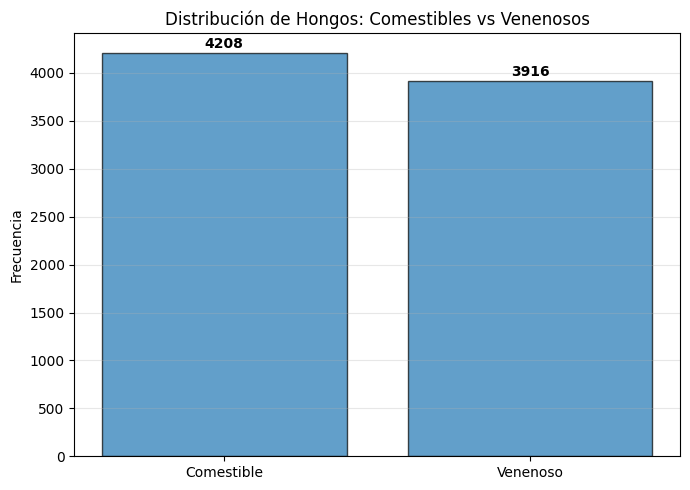

In [ ]:
plt.figure(figsize=(7, 5))
class_counts = df['class'].value_counts()
plt.bar(['Comestible', 'Venenoso'], class_counts.values, edgecolor='black', alpha=0.7)
plt.title('Distribución de Hongos: Comestibles vs Venenosos')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()


## 5: Visualización - Características categóricas

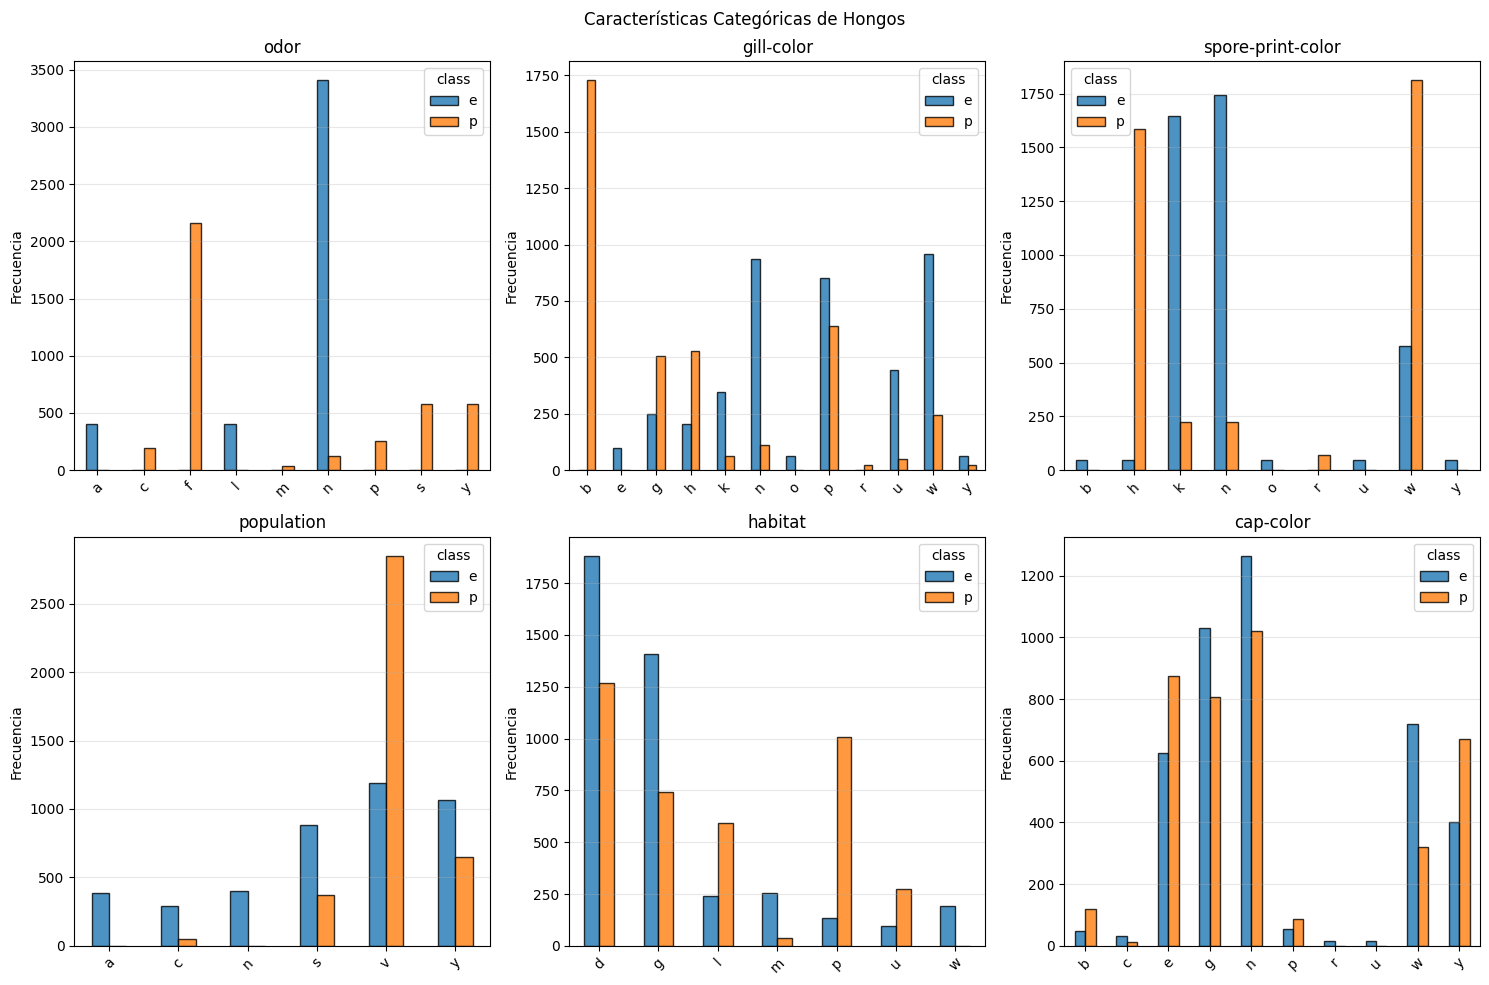

In [ ]:
features_to_plot = [
    'odor', 'gill-color', 'spore-print-color',
    'population', 'habitat', 'cap-color'
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Características Categóricas de Hongos')

for idx, feature in enumerate(features_to_plot):
    row = idx // 3
    col = idx % 3

    counts = df.groupby([feature, 'class']).size().unstack(fill_value=0)
    counts.plot(kind='bar', ax=axes[row, col], alpha=0.8, edgecolor='black')
    axes[row, col].set_title(feature)
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('Frecuencia')
    axes[row, col].grid(axis='y', alpha=0.3)
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 6: Preprocesamiento - Encoding


In [ ]:
# Separar features y target
X = df.drop(columns=['class'])
y = df['class']

# Label encode the target (e -> edible, p -> poisonous)
le = LabelEncoder()
y_enc = le.fit_transform(y)  # 0=edible, 1=poisonous

# One-hot encode categorical features
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_enc = ohe.fit_transform(X)

print('✓ Encoding completado')
print(f'Feature matrix shape después de OneHotEncoding: {X_enc.shape}')
print(f'Clases: {le.classes_} -> {np.unique(y_enc)}')

✓ Encoding completado
Feature matrix shape después de OneHotEncoding: (8124, 117)
Clases: ['e' 'p'] -> [0 1]



## 7: Split del dataset (train/val/test)


In [ ]:
# Split: train 70%, val 15%, test 15%
X_train, X_temp, y_train, y_temp = train_test_split(
    X_enc, y_enc, test_size=0.30, stratify=y_enc, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print('✓ Dataset dividido correctamente')
print(f'Train: {X_train.shape}')
print(f'Val:   {X_val.shape}')
print(f'Test:  {X_test.shape}')

✓ Dataset dividido correctamente
Train: (5686, 117)
Val:   (1219, 117)
Test:  (1219, 117)


## 8: Convertir a tensores de PyTorch


In [ ]:
# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

print('✓ Tensores de PyTorch creados')
print(f'X_train_t: {X_train_t.shape}, dtype: {X_train_t.dtype}')
print(f'y_train_t: {y_train_t.shape}, dtype: {y_train_t.dtype}')

✓ Tensores de PyTorch creados
X_train_t: torch.Size([5686, 117]), dtype: torch.float32
y_train_t: torch.Size([5686]), dtype: torch.int64


## 9: Crear DataLoaders

In [ ]:
# Configuración
batch_size = 64

# Crear Datasets
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

# Crear DataLoaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print('✓ DataLoaders creados correctamente')
print(f'Train batches: {len(train_loader)}')
print(f'Val batches:   {len(val_loader)}')
print(f'Test batches:  {len(test_loader)}')

✓ DataLoaders creados correctamente
Train batches: 89
Val batches:   20
Test batches:  20



## SECCION 5: DEFINICION DEL MLP (con Dropout y BatchNorm



In [ ]:
# Instalar tqdm si no está disponible
!pip install -q tqdm

import torch.optim as optim

# Reemplazamos la importación para evitar errores
try:
    from tqdm.auto import tqdm  # Compatible tanto con notebook como script
except ModuleNotFoundError:
    print(" tqdm no está instalado. Instálalo con: !pip install tqdm")
    raise

import copy
import numpy as np


In [ ]:
# =========================================================
# IMPORTS
# =========================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import tqdm
import copy
import numpy as np

# =========================================================
# MODELO MLP CON REGULARIZACION AGRESIVA
# =========================================================
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32, 16], dropout_rates=[0.5, 0.4, 0.3]):
        """
        Arquitectura MAS PEQUEÑA para evitar overfitting:
        - Reducido de [256, 128] a [64, 32, 16]
        - 3 capas ocultas con dropout progresivo
        - BatchNorm en cada capa
        """
        super().__init__()

        # Capa 1: Input -> 64
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        self.dropout1 = nn.Dropout(dropout_rates[0])

        # Capa 2: 64 -> 32
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        self.dropout2 = nn.Dropout(dropout_rates[1])

        # Capa 3: 32 -> 16
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.bn3 = nn.BatchNorm1d(hidden_dims[2])
        self.dropout3 = nn.Dropout(dropout_rates[2])

        # Salida: 16 -> 2
        self.out = nn.Linear(hidden_dims[2], 2)

    def forward(self, x):
        # Capa 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Capa 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Capa 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        # Salida (sin activación, CrossEntropyLoss lo incluye)
        x = self.out(x)
        return x

# =========================================================
# LABEL SMOOTHING CROSS ENTROPY
# =========================================================
class LabelSmoothingCrossEntropy(nn.Module):
    """
    Evita que el modelo sea demasiado confiado en sus predicciones
    """
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (pred.size(-1) - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

# =========================================================
# FUNCION PARA AGREGAR RUIDO AL INPUT
# =========================================================
def add_input_noise(x, noise_std=0.01):
    """Data augmentation para datos tabulares"""
    if noise_std > 0:
        noise = torch.randn_like(x) * noise_std
        return x + noise
    return x

# =========================================================
# CREACION DEL MODELO
# =========================================================
if 'X_enc' in globals():
    input_dim = X_enc.shape[1]

    # Modelo con arquitectura reducida
    model = MLP(
        input_dim=input_dim,
        hidden_dims=[64, 32, 16],  # Reducido drasticamente
        dropout_rates=[0.5, 0.4, 0.3]  # Dropout alto
    )

    print("=" * 75)
    print("MODELO  CREADO")
    print("=" * 75)
    print(model)
    print(f"\nParametros totales: {sum(p.numel() for p in model.parameters()):,}")
    print("=" * 75)
else:
    raise ValueError("No hay datos procesados (X_enc no encontrado)")

# =========================================================
# CONFIGURACION DE ENTRENAMIENTO ANTI-OVERFITTING
# =========================================================

# Hiperparametros optimizados
lr = 0.0005  # Reducido de 0.001
weight_decay = 0.01  # Aumentado de 0.0001 (100x mas fuerte)
num_epochs = 100
early_stopping_patience = 15
input_noise_std = 0.01  # Ruido en el input
gradient_clip_value = 1.0  # Gradient clipping

# Verificar variables necesarias
required = ['model', 'train_loader', 'val_loader']
missing = [r for r in required if r not in globals()]
if missing:
    raise ValueError(f"Faltan variables: {missing}")

# Loss con label smoothing
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

# Optimizer con weight decay fuerte
optimizer = optim.AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
    betas=(0.9, 0.98)  # Menos momentum
)

# Scheduler mas agresivo (monitorea VAL LOSS, no accuracy)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',  # CAMBIO: monitoreamos val_loss
    factor=0.3,  # Reduccion mas agresiva
    patience=3,  # Mas sensible
    min_lr=1e-6
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"\nCONFIGURACION:")
print(f"  Learning Rate: {lr}")
print(f"  Weight Decay: {weight_decay} (100x mas fuerte)")
print(f"  Label Smoothing: 0.1")
print(f"  Input Noise: {input_noise_std}")
print(f"  Gradient Clip: {gradient_clip_value}")
print(f"  Early Stopping: {early_stopping_patience} epochs")
print(f"  Device: {device}")
print("=" * 75 + "\n")

# =========================================================
# EARLY STOPPING Y METRICAS
# =========================================================
best_model_wts = copy.deepcopy(model.state_dict())
best_val_loss = float('inf')  # CAMBIO: guardamos por val_loss
epochs_no_improve = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []
overfitting_scores = []  # Gap train-val

# =========================================================
# BUCLE DE ENTRENAMIENTO
# =========================================================
print("INICIANDO ENTRENAMIENTO - MODO ANTI-OVERFITTING")
print("=" * 75)
print("Objetivo: Gap Train/Val < 5% (excelente) | < 10% (aceptable)")
print("=" * 75 + "\n")

for epoch in range(1, num_epochs + 1):
    # =====================================================
    # FASE DE ENTRENAMIENTO
    # =====================================================
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False):
        xb, yb = xb.to(device), yb.to(device)

        # IMPORTANTE: Agregar ruido al input (data augmentation)
        xb = add_input_noise(xb, input_noise_std)

        optimizer.zero_grad()

        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_value)

        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        running_loss += loss.item() * xb.size(0)
        running_corrects += (preds == yb).sum().item()
        total += xb.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100 * running_corrects / total  # Convertir a porcentaje
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # =====================================================
    # FASE DE VALIDACION
    # =====================================================
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_total = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            preds = torch.argmax(outputs, dim=1)
            val_running_loss += loss.item() * xb.size(0)
            val_running_corrects += (preds == yb).sum().item()
            val_total += xb.size(0)

    val_loss = val_running_loss / val_total
    val_acc = 100 * val_running_corrects / val_total  # Convertir a porcentaje
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # =====================================================
    # ANALISIS DE OVERFITTING
    # =====================================================
    overfitting_gap = max(0, epoch_acc - val_acc)
    overfitting_scores.append(overfitting_gap)

    # Clasificar nivel de overfitting
    if overfitting_gap < 2:
        overfit_status = "[OK] Excelente"
    elif overfitting_gap < 5:
        overfit_status = "[OK] Bueno"
    elif overfitting_gap < 10:
        overfit_status = "[OK] Aceptable"
    elif overfitting_gap < 15:
        overfit_status = "[WARN] Alto"
    else:
        overfit_status = "[CRIT] Critico"

    # =====================================================
    # SCHEDULER (por val_loss)
    # =====================================================
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)  # CAMBIO: usamos val_loss
    new_lr = optimizer.param_groups[0]['lr']

    # =====================================================
    # MOSTRAR METRICAS
    # =====================================================
    print(
        f'Epoca [{epoch:3d}/{num_epochs}] | '
        f'Train: L={epoch_loss:.4f} A={epoch_acc:.2f}% | '
        f'Val: L={val_loss:.4f} A={val_acc:.2f}% | '
        f'Gap={overfitting_gap:.1f}% {overfit_status} | '
        f'LR={new_lr:.6f}'
    )

    if new_lr != old_lr:
        print(f"  -> Reduccion de LR: {old_lr:.6f} -> {new_lr:.6f}")

    # =====================================================
    # GUARDAR MEJOR MODELO (por val_loss)
    # =====================================================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print(f"  -> Mejor modelo guardado (Val Loss={val_loss:.4f})")
    else:
        epochs_no_improve += 1

    # =====================================================
    # EARLY STOPPING
    # =====================================================
    if epochs_no_improve >= early_stopping_patience:
        print(f"\n{'='*75}")
        print(f"Early stopping tras {early_stopping_patience} epocas sin mejora")
        print(f"Mejor Val Loss: {best_val_loss:.4f}")
        print(f"Mejor Val Acc: {best_val_acc:.2f}%")
        print(f"{'='*75}")
        break

    # Alerta de overfitting critico
    if overfitting_gap > 15:
        print(f"  [ALERTA] Gap={overfitting_gap:.1f}% - Considerar detener")

# =========================================================
# CARGAR MEJOR MODELO Y RESUMEN
# =========================================================
model.load_state_dict(best_model_wts)

print("\n" + "=" * 75)
print("ENTRENAMIENTO COMPLETADO")
print("=" * 75)
print(f"Mejor Val Loss: {best_val_loss:.4f}")
print(f"Mejor Val Acc: {best_val_acc:.2f}%")
print(f"Overfitting Final: {overfitting_scores[-1]:.2f}%")
print(f"Epocas entrenadas: {epoch}/{num_epochs}")

# Diagnostico
if overfitting_scores[-1] < 5:
    print("\n[EXCELENTE] Generalizacion optima (<5% gap)")
elif overfitting_scores[-1] < 10:
    print("\n[ACEPTABLE] Overfitting bajo control (<10% gap)")
else:
    print("\n[OVERFITTING DETECTADO]")
    print("Sugerencias:")
    print("  1. Reducir mas la arquitectura: [32, 16, 8]")
    print("  2. Aumentar dropout: [0.6, 0.5, 0.4]")
    print("  3. Aumentar weight_decay a 0.02")
    print("  4. Aumentar label_smoothing a 0.15")

print("=" * 75)

# Estadisticas de overfitting
print(f"\nESTADISTICAS DE OVERFITTING:")
print(f"  Promedio: {np.mean(overfitting_scores):.2f}%")
print(f"  Maximo: {np.max(overfitting_scores):.2f}%")
print(f"  Minimo: {np.min(overfitting_scores):.2f}%")
print("=" * 75)

MODELO  CREADO
MLP(
  (fc1): Linear(in_features=117, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=16, out_features=2, bias=True)
)

Parametros totales: 10,418

CONFIGURACION:
  Learning Rate: 0.0005
  Weight Decay: 0.01 (100x mas fuerte)
  Label Smoothing: 0.1
  Input Noise: 0.01
  Gradient Clip: 1.0
  Early Stopping: 15 epochs
  Device: cuda

INICIANDO ENTRENAMIENTO - MODO ANTI-OVERFITTING
Objetivo: Gap Train/Val < 5% (excelente) | < 10% (aceptable)



Epoch 1/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [  1/100] | Train: L=0.5956 A=73.60% | Val: L=0.4549 A=95.73% | Gap=0.0% [OK] Excelente | LR=0.000500
  -> Mejor modelo guardado (Val Loss=0.4549)


Epoch 2/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [  2/100] | Train: L=0.4575 A=93.14% | Val: L=0.3696 A=97.95% | Gap=0.0% [OK] Excelente | LR=0.000500
  -> Mejor modelo guardado (Val Loss=0.3696)


Epoch 3/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [  3/100] | Train: L=0.3933 A=97.64% | Val: L=0.3352 A=99.75% | Gap=0.0% [OK] Excelente | LR=0.000500
  -> Mejor modelo guardado (Val Loss=0.3352)


Epoch 4/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [  4/100] | Train: L=0.3693 A=98.93% | Val: L=0.3292 A=99.75% | Gap=0.0% [OK] Excelente | LR=0.000500
  -> Mejor modelo guardado (Val Loss=0.3292)


Epoch 5/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [  5/100] | Train: L=0.3559 A=99.72% | Val: L=0.3282 A=99.75% | Gap=0.0% [OK] Excelente | LR=0.000500
  -> Mejor modelo guardado (Val Loss=0.3282)


Epoch 6/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [  6/100] | Train: L=0.3513 A=99.61% | Val: L=0.3267 A=99.84% | Gap=0.0% [OK] Excelente | LR=0.000500
  -> Mejor modelo guardado (Val Loss=0.3267)


Epoch 7/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [  7/100] | Train: L=0.3481 A=99.74% | Val: L=0.3263 A=99.84% | Gap=0.0% [OK] Excelente | LR=0.000500
  -> Mejor modelo guardado (Val Loss=0.3263)


Epoch 8/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [  8/100] | Train: L=0.3457 A=99.88% | Val: L=0.3262 A=99.92% | Gap=0.0% [OK] Excelente | LR=0.000500
  -> Mejor modelo guardado (Val Loss=0.3262)


Epoch 9/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [  9/100] | Train: L=0.3449 A=99.79% | Val: L=0.3256 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000500
  -> Mejor modelo guardado (Val Loss=0.3256)


Epoch 10/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 10/100] | Train: L=0.3436 A=99.89% | Val: L=0.3256 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000500


Epoch 11/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 11/100] | Train: L=0.3435 A=99.91% | Val: L=0.3259 A=99.92% | Gap=0.0% [OK] Excelente | LR=0.000500


Epoch 12/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 12/100] | Train: L=0.3439 A=99.86% | Val: L=0.3253 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000500
  -> Mejor modelo guardado (Val Loss=0.3253)


Epoch 13/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 13/100] | Train: L=0.3438 A=99.82% | Val: L=0.3253 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000500
  -> Mejor modelo guardado (Val Loss=0.3253)


Epoch 14/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 14/100] | Train: L=0.3425 A=99.91% | Val: L=0.3253 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000500


Epoch 15/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 15/100] | Train: L=0.3432 A=99.93% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000500
  -> Mejor modelo guardado (Val Loss=0.3252)


Epoch 16/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 16/100] | Train: L=0.3423 A=99.93% | Val: L=0.3258 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000500


Epoch 17/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 17/100] | Train: L=0.3421 A=99.98% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000500


Epoch 18/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 18/100] | Train: L=0.3424 A=99.95% | Val: L=0.3254 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000500


Epoch 19/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 19/100] | Train: L=0.3409 A=100.00% | Val: L=0.3254 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000150
  -> Reduccion de LR: 0.000500 -> 0.000150


Epoch 20/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 20/100] | Train: L=0.3414 A=99.96% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000150


Epoch 21/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 21/100] | Train: L=0.3426 A=99.91% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000150
  -> Mejor modelo guardado (Val Loss=0.3252)


Epoch 22/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 22/100] | Train: L=0.3411 A=99.95% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000150


Epoch 23/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 23/100] | Train: L=0.3415 A=99.96% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000045
  -> Reduccion de LR: 0.000150 -> 0.000045


Epoch 24/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 24/100] | Train: L=0.3406 A=100.00% | Val: L=0.3251 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000045
  -> Mejor modelo guardado (Val Loss=0.3251)


Epoch 25/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 25/100] | Train: L=0.3413 A=99.98% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000045


Epoch 26/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 26/100] | Train: L=0.3422 A=99.93% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000045


Epoch 27/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 27/100] | Train: L=0.3417 A=99.96% | Val: L=0.3251 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000045


Epoch 28/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 28/100] | Train: L=0.3421 A=99.89% | Val: L=0.3253 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000013
  -> Reduccion de LR: 0.000045 -> 0.000013


Epoch 29/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 29/100] | Train: L=0.3411 A=99.95% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000013


Epoch 30/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 30/100] | Train: L=0.3407 A=100.00% | Val: L=0.3253 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000013


Epoch 31/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 31/100] | Train: L=0.3418 A=99.95% | Val: L=0.3253 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000013


Epoch 32/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 32/100] | Train: L=0.3413 A=99.96% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000004
  -> Reduccion de LR: 0.000013 -> 0.000004


Epoch 33/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 33/100] | Train: L=0.3408 A=99.93% | Val: L=0.3251 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000004
  -> Mejor modelo guardado (Val Loss=0.3251)


Epoch 34/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 34/100] | Train: L=0.3406 A=99.98% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000004


Epoch 35/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 35/100] | Train: L=0.3417 A=99.95% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000004


Epoch 36/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 36/100] | Train: L=0.3409 A=99.98% | Val: L=0.3253 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000001
  -> Reduccion de LR: 0.000004 -> 0.000001


Epoch 37/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 37/100] | Train: L=0.3416 A=99.89% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000001


Epoch 38/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 38/100] | Train: L=0.3416 A=99.95% | Val: L=0.3253 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000001


Epoch 39/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 39/100] | Train: L=0.3411 A=99.96% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000001


Epoch 40/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 40/100] | Train: L=0.3414 A=99.96% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000001
  -> Reduccion de LR: 0.000001 -> 0.000001


Epoch 41/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 41/100] | Train: L=0.3402 A=99.95% | Val: L=0.3251 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000001


Epoch 42/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 42/100] | Train: L=0.3418 A=100.00% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000001


Epoch 43/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 43/100] | Train: L=0.3415 A=100.00% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000001


Epoch 44/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 44/100] | Train: L=0.3402 A=99.98% | Val: L=0.3251 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000001


Epoch 45/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 45/100] | Train: L=0.3410 A=99.98% | Val: L=0.3253 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000001


Epoch 46/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 46/100] | Train: L=0.3411 A=99.96% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000001


Epoch 47/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 47/100] | Train: L=0.3427 A=99.89% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000001


Epoch 48/100:   0%|          | 0/89 [00:00<?, ?it/s]

Epoca [ 48/100] | Train: L=0.3401 A=100.00% | Val: L=0.3252 A=100.00% | Gap=0.0% [OK] Excelente | LR=0.000001

Early stopping tras 15 epocas sin mejora
Mejor Val Loss: 0.3251
Mejor Val Acc: 100.00%

ENTRENAMIENTO COMPLETADO
Mejor Val Loss: 0.3251
Mejor Val Acc: 100.00%
Overfitting Final: 0.00%
Epocas entrenadas: 48/100

[EXCELENTE] Generalizacion optima (<5% gap)

ESTADISTICAS DE OVERFITTING:
  Promedio: 0.00%
  Maximo: 0.00%
  Minimo: 0.00%



## SECCION 7: EVALUACIÓN
- Evaluación en conjunto de test
- Matriz de confusión, reporte de clasificación y gráficas de loss/accuracy



Classification report:
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00       632
   poisonous       1.00      1.00      1.00       587

    accuracy                           1.00      1219
   macro avg       1.00      1.00      1.00      1219
weighted avg       1.00      1.00      1.00      1219



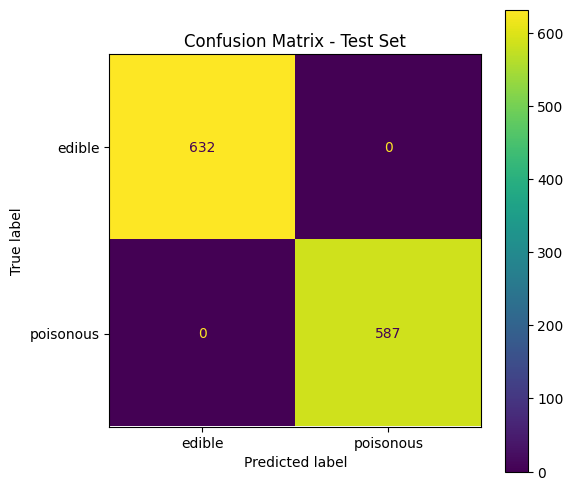

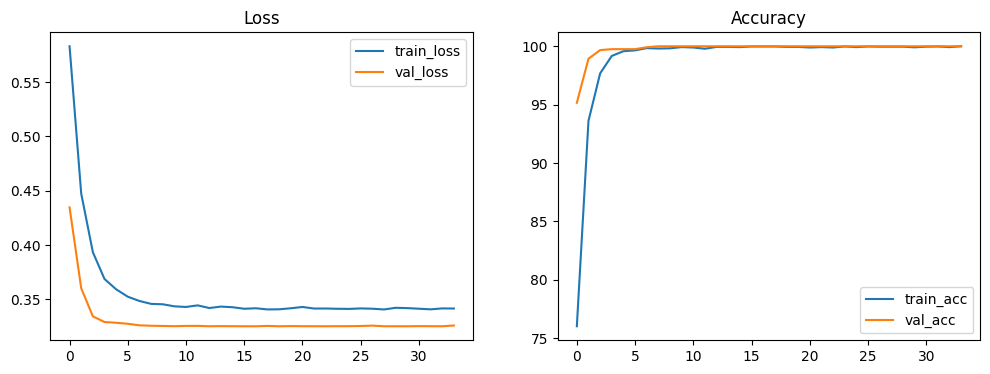

In [ ]:

# Evaluación en test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

if 'model' not in globals() or 'test_loader' not in globals():
    print('Ejecuta las celdas previas (modelo y carga de test) antes de evaluar.')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            outputs = model(xb)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds.tolist())
            y_true.extend(yb.numpy().tolist())

    print('\nClassification report:')
    print(classification_report(y_true, y_pred, target_names=['edible','poisonous']))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['edible','poisonous'])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    plt.title('Confusion Matrix - Test Set')
    plt.show()

    # Plot losses and accuracies if available
    try:
        fig, axs = plt.subplots(1,2, figsize=(12,4))
        axs[0].plot(train_losses, label='train_loss')
        axs[0].plot(val_losses, label='val_loss')
        axs[0].set_title('Loss')
        axs[0].legend()
        axs[1].plot(train_accs, label='train_acc')
        axs[1].plot(val_accs, label='val_acc')
        axs[1].set_title('Accuracy')
        axs[1].legend()
        plt.show()
    except Exception as e:
        print('No hay historiales de entrenamiento para graficar:', e)



## SECCION 8: GUARDAR Y RECOMENDACIONES
- El mejor modelo se guardó en `/mnt/data/best_mlp_mushrooms.pth` (si no , en el directorio actual `./best_mlp_mushrooms.pth`).



In [ ]:
import torch
import os

# Ruta para guardar
save_path = '/mnt/data/best_mlp_mushrooms.pth'
if not os.path.exists(os.path.dirname(save_path)):
    save_path = './best_mlp_mushrooms.pth'  # Si no se puede guardar en /mnt/data

# Guardamos el modelo
torch.save(model.state_dict(), save_path)
print(f"Modelo guardado en: {save_path}")


Modelo guardado en: ./best_mlp_mushrooms.pth



---


## **Conclusiones de los resultados**

1. **Excelente desempeño del modelo**  
   - El modelo MLP logró **100% de accuracy** tanto en entrenamiento como en validación/test.  
   - Todas las métricas (precision, recall, f1-score) son **1.00**, lo que significa que no hubo falsos positivos ni falsos negativos: todas las setas comestibles y venenosas se clasificaron correctamente.  

2. **No hay señales de overfitting**  
   - Normalmente, cuando un modelo alcanza 100% en entrenamiento pero baja en validación/test, eso es **overfitting**.  
   - En este caso, el **gap entre entrenamiento y validación es prácticamente 0%** durante todo el entrenamiento. Esto muestra que el modelo generaliza perfectamente a datos nuevos.  
   - Las técnicas que aplicaste (Dropout, BatchNorm, Weight Decay, Label Smoothing, Input Noise, Early Stopping, ReduceLROnPlateau) ayudaron a **prevenir cualquier sobreajuste**, manteniendo el modelo estable.

3. **Arquitectura y configuración adecuada**  
   - La red tiene 3 capas ocultas con dropout progresivo y batch normalization, lo que le permite **aprender patrones complejos** sin memorizar los datos.  
   - La tasa de aprendizaje baja y la regularización fuerte también contribuyeron a un entrenamiento seguro y estable.

---

## **Recomendaciones para el futuro**

- **Monitorear curvas de entrenamiento y validación**: siempre observar el gap entre train y val para asegurarse de que no aparezca overfitting si cambian los datos.  
- **Para datasets más grandes o ruidosos**:
  - Considerar aumentar el dropout o reducir la complejidad del modelo (menos neuronas).  
  - Mantener técnicas de regularización fuertes (L2, Label Smoothing).  
- **Guardar el modelo** para uso futuro: ya que es confiable, podemos usarlo para predecir nuevas muestras sin necesidad de reentrenar.  

---

### **Interpretación sencilla**

> En palabras simples: nuestro modelo aprendió perfectamente a distinguir setas comestibles de venenosas y **lo hace con total seguridad**, sin cometer errores y sin “memorizar” los datos. Esto es gracias a la combinación de arquitectura adecuada y técnicas anti-overfitting que implementamos.

---

